### models from https://github.com/qubvel/segmentation_models.pytorch

In [1]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import ast
import copy
import gc
import glob
import json
import os
import random

import albumentations
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import skimage
import torch
import wandb
from IPython.core.interactiveshell import InteractiveShell
from torch.optim import lr_scheduler
from tqdm import tqdm

from src.dataset_utils import Dataset, create_transform
from src.train_utils import dice_score, iou_score, seed_everything, train

InteractiveShell.ast_node_interactivity = "all"

In [3]:
wandb.init(dir="/app/_data/", project="tract_segmentation_main")

wandb: Currently logged in as: tatanko. Use `wandb login --relogin` to force relogin


## Train configuration

In [4]:
with open("/app/_data/base_config.json", "r") as f:
    CONFIG = json.load(f)

In [5]:
CONFIG

{'IMG_SIZE': [384, 384],
 'BATCH_SIZE': 18,
 'SEED': 38,
 'ENCODER': 'timm-efficientnet-b4',
 'ENCODER_WEIGHTS': 'noisy-student',
 'MODEL_PATH': '/app/_data/models/model1/',
 'MODEL_NAME': 'DeepLabV3Plus',
 'SEQUENCE': False,
 'N_CHANELS': 1,
 'MODEL_TYPE': 'one_input',
 'NORMALIZE': True,
 'FOLD': 1,
 'UINT8': False,
 'DEVICE': 'cuda',
 'LABELS': {'0': 'large_bowel', '1': 'small_bowel', '2': 'stomach'}}

In [6]:
CONFIG["FOLD"] = 1
CONFIG["SEED"] = 42
CONFIG["NORMALIZE"] = True
CONFIG["BATCH_SIZE"] = 36
CONFIG["N_CHANELS"] = 3
CONFIG[
    "MODEL_PATH"
] = f"/app/_data/models/unet_fold_{CONFIG['FOLD']}_two_sided_seed_{CONFIG['SEED']}_seq_1/"
CONFIG["SEQUENCE"] = True
CONFIG["STEP"] = 1

## Dataframe

In [7]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)

In [8]:
df["3D_npy_bf"] = "/app/_data/3D_npy_bf/" + df["id"] + ".npy"
transform_func = create_transform(CONFIG["IMG_SIZE"])

In [9]:
train_ds = Dataset(
    df=df[df["fold"] != CONFIG["FOLD"]].sample(len(df[df["fold"] != CONFIG["FOLD"]]) // CONFIG["BATCH_SIZE"] * CONFIG["BATCH_SIZE"]),
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3D_npy_bf",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=transform_func,
    pad=True,
)
val_ds = Dataset(
    df=df[df["fold"] == CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3D_npy_bf",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=None,
    pad=True,
)

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=CONFIG["BATCH_SIZE"] * 2, shuffle=True, num_workers=0
)

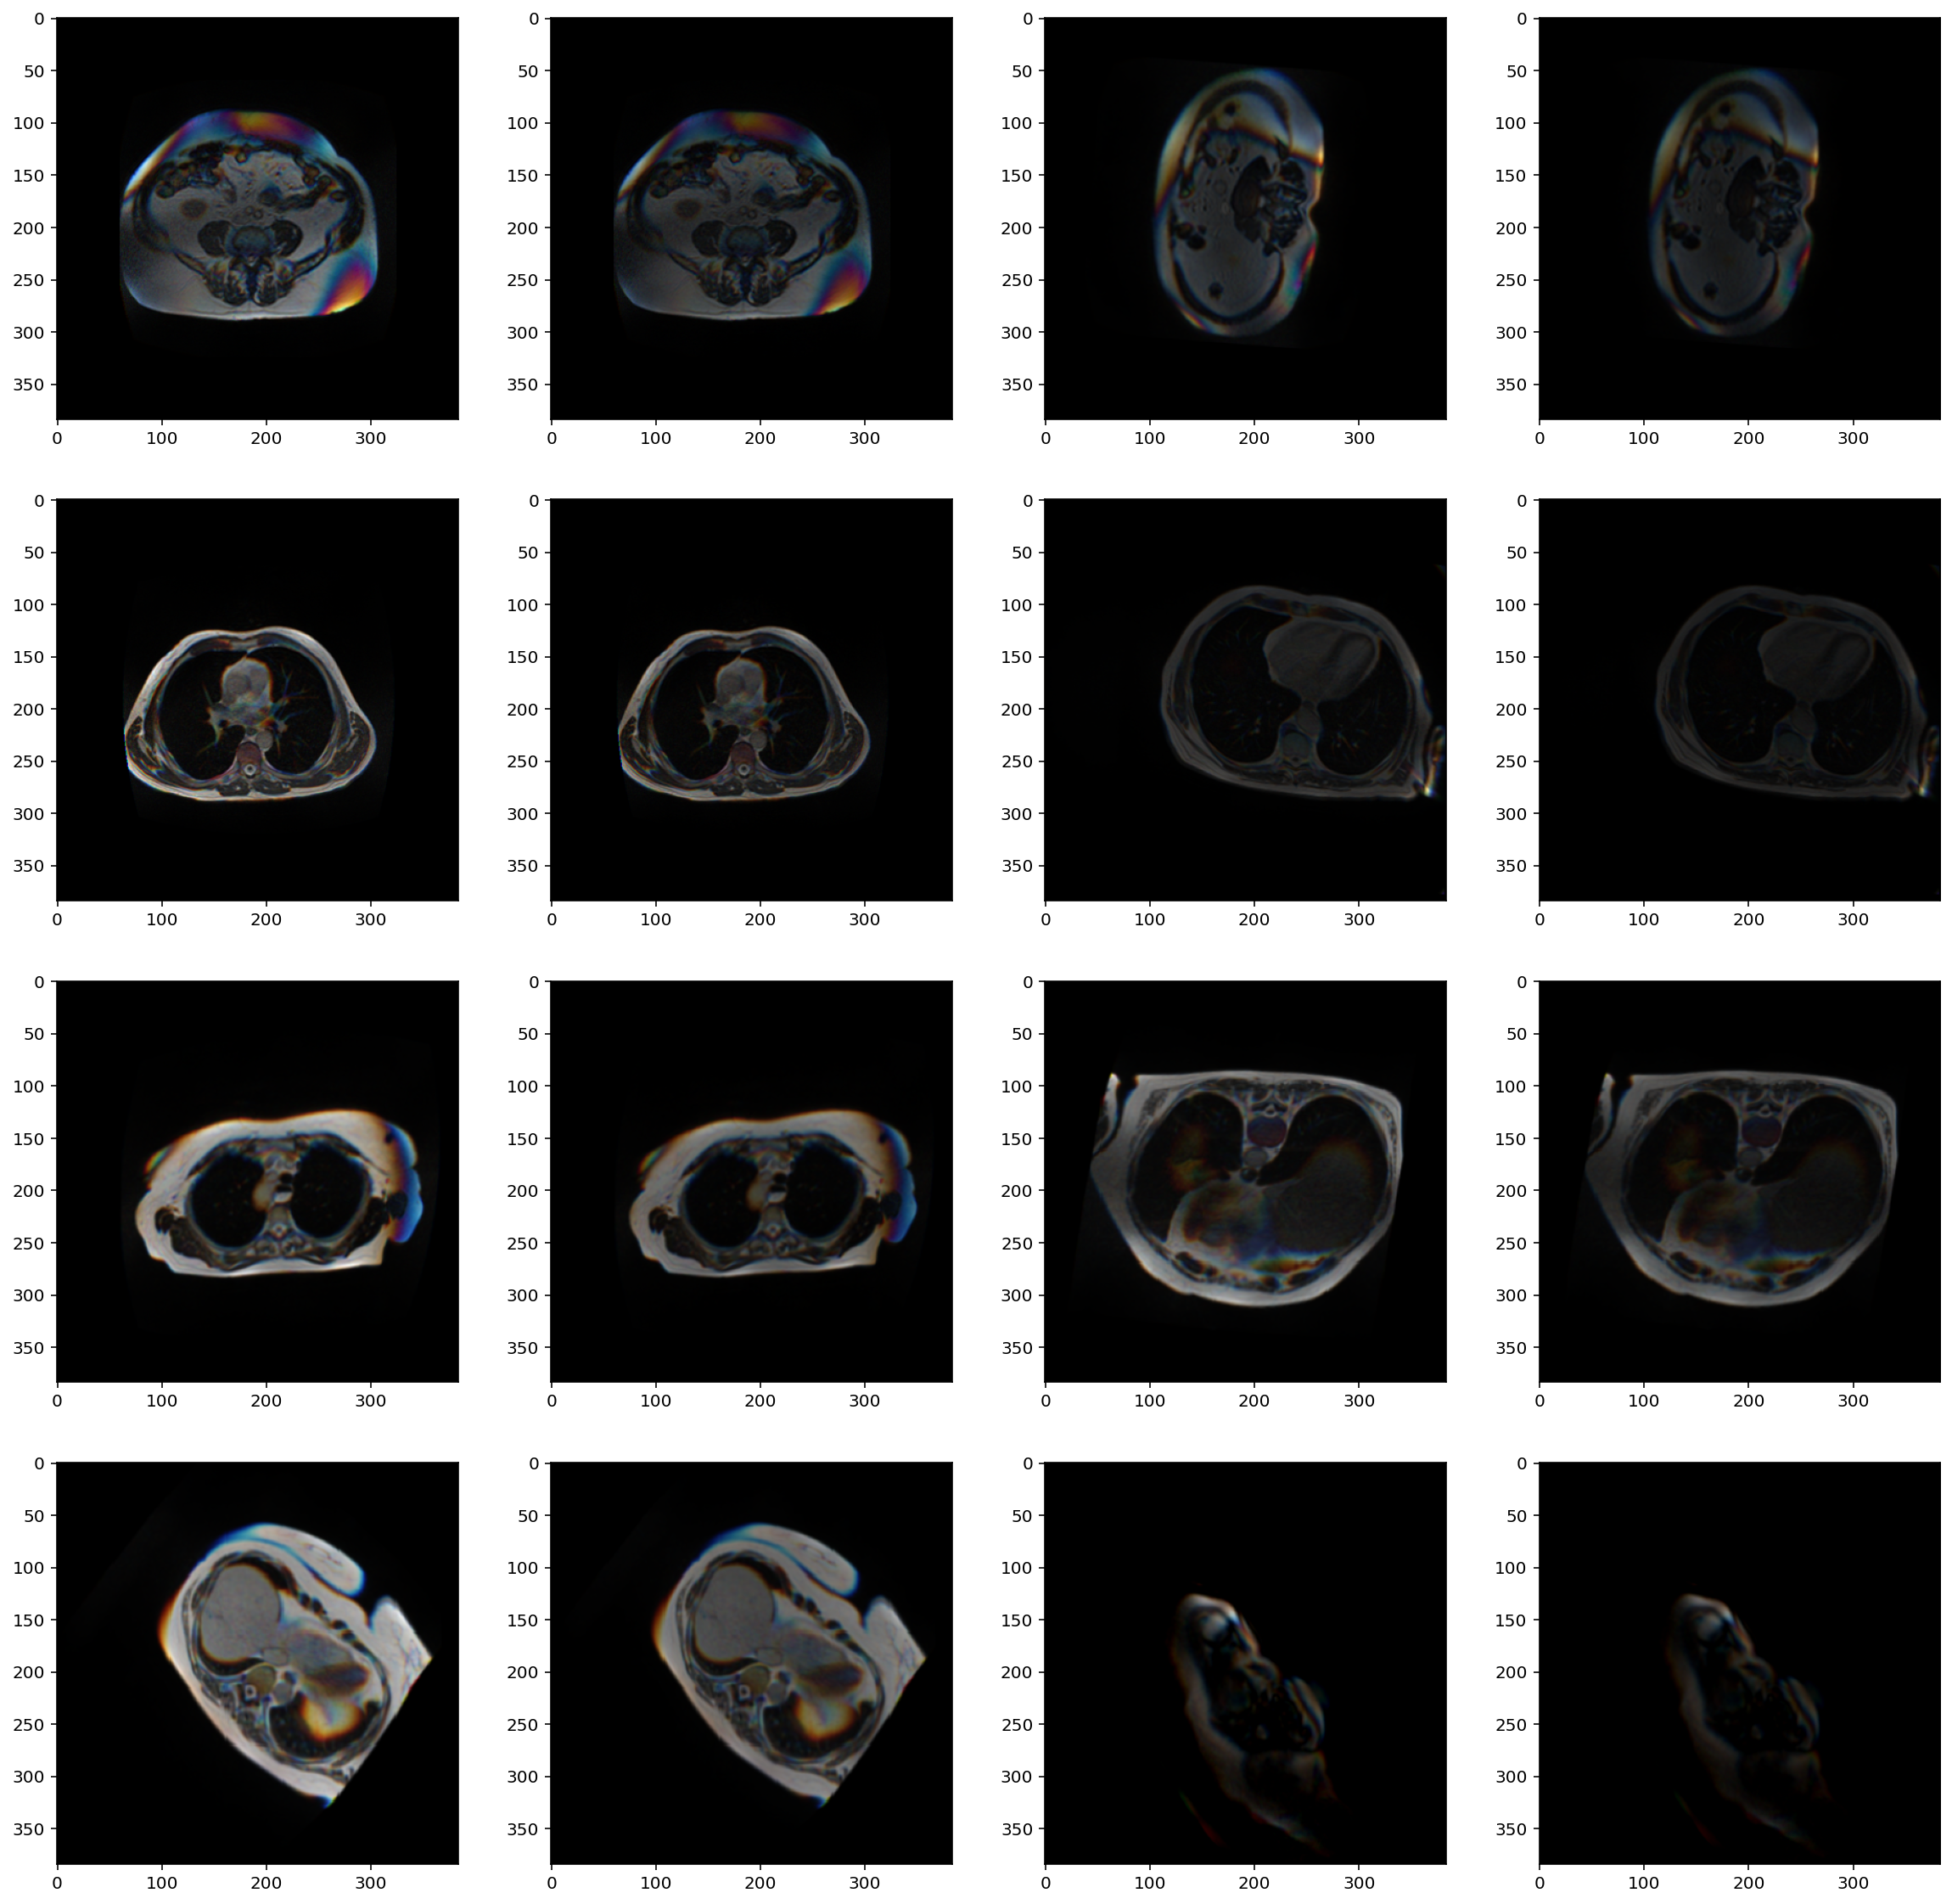

In [11]:
plt.figure(figsize=(20, 20))
for i in range(0, 16, 2):
    ix = np.random.randint(0, len(train_ds))
    img, mask = train_ds[ix]
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.subplot(4, 4, i + 2)
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask, 0, 2), alpha=0.3)
plt.show();

## model

In [12]:
model = smp.Unet(
    encoder_name=CONFIG["ENCODER"],
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_channels=(256, 128, 64, 32, 16),
    in_channels=3,
    decoder_attention_type = 'scse',
    classes=3,
    decoder_use_batchnorm=True,
    activation=None,
    aux_params=None,
)
model = model.to(CONFIG["DEVICE"])

In [13]:
# weights = torch.load(
#     "/app/_data/models/deeplab_fold_1_two_sided_seed_42_seq_2/weights/best_dice_weights_9263.pth"
# )
# model.load_state_dict(weights)

In [14]:
JaccardLoss = smp.losses.JaccardLoss(mode="multilabel", from_logits=True)
DiceLoss = smp.losses.DiceLoss(mode="multilabel", from_logits=True)
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode="multilabel", per_image=True)
TverskyLoss = smp.losses.TverskyLoss(
    mode="multilabel", log_loss=False, from_logits=True, alpha=0.7, beta=0.3
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-6)


def loss_fn(y_pred, y_true):
    return 0.7 * DiceLoss(y_pred, y_true) + 0.3 * BCELoss(y_pred, y_true)


def loss_fn(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

In [15]:
history, best_weights = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=50,
    config=CONFIG,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=loss_fn,
    wandb_log=True,
    early_stopping=4,
)

Train: epoch #1: 100% 900/900 [36:46<00:00,  2.45s/it, current_dice=0.8670, epoch_dice=0.7385, gpu_memory=20.38 GB, lr=0.000994, train_loss=0.4568]
Val:   epoch #1:   0% 0/81 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)
Val:   epoch #1: 100% 81/81 [02:28<00:00,  1.83s/it, current_dice=0.8623, current_iou=0.8285, epoch_dice=0.8684, epoch_hd=5.4510, epoch_iou=0.8360, gpu_memory=9.61 GB, val_loss=0.2613]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #2: 100% 900/900 [35:30<00:00,  2.37s/it, current_dice=0.8481, epoch_dice=0.8576, gpu_memory=20.69 GB, lr=0.000976, train_loss=0.2796]
Val:   epoch #2: 100% 81/81 [02:27<00:00,  1.82s/it, current_dice=0.9052, current_iou=0.8786, epoch_dice=0.9038, epoch_hd=4.6976, epoch_iou=0.8759, gpu_memory=9.62 GB, val_loss=0.1963]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #3: 100% 900/900 [36:57<00:00,  2.46s/it, current_dice=0.8382, epoch_dice=0.8763, gpu_memory=20.73 GB, lr=0.000946, train_loss=0.2437]
Val:   epoch #3: 100% 81/81 [02:29<00:00,  1.85s/it, current_dice=0.9078, current_iou=0.8704, epoch_dice=0.8935, epoch_hd=7.1133, epoch_iou=0.8643, gpu_memory=9.62 GB, val_loss=0.2009]


Train: epoch #4: 100% 900/900 [35:56<00:00,  2.40s/it, current_dice=0.8529, epoch_dice=0.8856, gpu_memory=20.73 GB, lr=0.000905, train_loss=0.2284]
Val:   epoch #4: 100% 81/81 [02:20<00:00,  1.74s/it, current_dice=0.9518, current_iou=0.9320, epoch_dice=0.9098, epoch_hd=4.7723, epoch_iou=0.8824, gpu_memory=9.62 GB, val_loss=0.1818]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #5: 100% 900/900 [35:09<00:00,  2.34s/it, current_dice=0.8682, epoch_dice=0.8925, gpu_memory=20.69 GB, lr=0.000854, train_loss=0.2158]
Val:   epoch #5: 100% 81/81 [02:29<00:00,  1.85s/it, current_dice=0.8966, current_iou=0.8765, epoch_dice=0.9092, epoch_hd=4.2616, epoch_iou=0.8820, gpu_memory=9.62 GB, val_loss=0.1825]


Train: epoch #6: 100% 900/900 [36:36<00:00,  2.44s/it, current_dice=0.9429, epoch_dice=0.9009, gpu_memory=20.69 GB, lr=0.000794, train_loss=0.2037]
Val:   epoch #6: 100% 81/81 [02:29<00:00,  1.85s/it, current_dice=0.8828, current_iou=0.8481, epoch_dice=0.9138, epoch_hd=3.3545, epoch_iou=0.8868, gpu_memory=9.62 GB, val_loss=0.1761]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #7: 100% 900/900 [36:12<00:00,  2.41s/it, current_dice=0.9193, epoch_dice=0.9062, gpu_memory=20.69 GB, lr=0.000727, train_loss=0.1954]
Val:   epoch #7: 100% 81/81 [02:23<00:00,  1.77s/it, current_dice=0.9569, current_iou=0.9346, epoch_dice=0.9166, epoch_hd=4.2276, epoch_iou=0.8904, gpu_memory=9.62 GB, val_loss=0.1685]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #8: 100% 900/900 [35:41<00:00,  2.38s/it, current_dice=0.9031, epoch_dice=0.9073, gpu_memory=20.73 GB, lr=0.000655, train_loss=0.1931]
Val:   epoch #8: 100% 81/81 [02:26<00:00,  1.81s/it, current_dice=0.9566, current_iou=0.9337, epoch_dice=0.9159, epoch_hd=3.8458, epoch_iou=0.8892, gpu_memory=9.63 GB, val_loss=0.1695]


Train: epoch #9: 100% 900/900 [36:42<00:00,  2.45s/it, current_dice=0.9373, epoch_dice=0.9117, gpu_memory=20.73 GB, lr=0.000579, train_loss=0.1846]
Val:   epoch #9: 100% 81/81 [02:28<00:00,  1.84s/it, current_dice=0.9191, current_iou=0.8873, epoch_dice=0.9182, epoch_hd=4.5610, epoch_iou=0.8919, gpu_memory=9.63 GB, val_loss=0.1690]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #10: 100% 900/900 [36:13<00:00,  2.42s/it, current_dice=0.9137, epoch_dice=0.9160, gpu_memory=20.73 GB, lr=0.000501, train_loss=0.1774]
Val:   epoch #10: 100% 81/81 [02:23<00:00,  1.77s/it, current_dice=0.9355, current_iou=0.9159, epoch_dice=0.9263, epoch_hd=3.4374, epoch_iou=0.9015, gpu_memory=9.64 GB, val_loss=0.1643]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #11: 100% 900/900 [35:26<00:00,  2.36s/it, current_dice=0.9698, epoch_dice=0.9183, gpu_memory=20.73 GB, lr=0.000422, train_loss=0.1726]
Val:   epoch #11: 100% 81/81 [02:28<00:00,  1.83s/it, current_dice=0.9503, current_iou=0.9400, epoch_dice=0.9204, epoch_hd=2.7768, epoch_iou=0.8964, gpu_memory=9.63 GB, val_loss=0.1862]


Train: epoch #12: 100% 900/900 [36:36<00:00,  2.44s/it, current_dice=0.9368, epoch_dice=0.9225, gpu_memory=20.73 GB, lr=0.000346, train_loss=0.1657]
Val:   epoch #12: 100% 81/81 [02:29<00:00,  1.84s/it, current_dice=0.9634, current_iou=0.9423, epoch_dice=0.9268, epoch_hd=2.5550, epoch_iou=0.9027, gpu_memory=9.63 GB, val_loss=0.1691]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #13: 100% 900/900 [36:09<00:00,  2.41s/it, current_dice=0.9646, epoch_dice=0.9244, gpu_memory=20.73 GB, lr=0.000274, train_loss=0.1623]
Val:   epoch #13: 100% 81/81 [02:23<00:00,  1.77s/it, current_dice=0.9275, current_iou=0.8987, epoch_dice=0.9293, epoch_hd=3.1101, epoch_iou=0.9046, gpu_memory=9.71 GB, val_loss=0.1601]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #14: 100% 900/900 [35:43<00:00,  2.38s/it, current_dice=0.8876, epoch_dice=0.9273, gpu_memory=20.76 GB, lr=0.000207, train_loss=0.1572]
Val:   epoch #14: 100% 81/81 [02:27<00:00,  1.82s/it, current_dice=0.9610, current_iou=0.9429, epoch_dice=0.9283, epoch_hd=3.1832, epoch_iou=0.9049, gpu_memory=9.72 GB, val_loss=0.1634]


Train: epoch #15: 100% 900/900 [36:45<00:00,  2.45s/it, current_dice=0.9353, epoch_dice=0.9285, gpu_memory=20.76 GB, lr=0.000147, train_loss=0.1538]
Val:   epoch #15: 100% 81/81 [02:29<00:00,  1.84s/it, current_dice=0.9439, current_iou=0.9174, epoch_dice=0.9299, epoch_hd=3.0458, epoch_iou=0.9057, gpu_memory=9.72 GB, val_loss=0.1592]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #16: 100% 900/900 [35:58<00:00,  2.40s/it, current_dice=0.9535, epoch_dice=0.9314, gpu_memory=20.76 GB, lr=0.000096, train_loss=0.1500]
Val:   epoch #16: 100% 81/81 [02:24<00:00,  1.78s/it, current_dice=0.9506, current_iou=0.9297, epoch_dice=0.9310, epoch_hd=2.9509, epoch_iou=0.9064, gpu_memory=9.72 GB, val_loss=0.1527]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #17: 100% 900/900 [35:30<00:00,  2.37s/it, current_dice=0.9359, epoch_dice=0.9331, gpu_memory=20.73 GB, lr=0.000055, train_loss=0.1472]
Val:   epoch #17: 100% 81/81 [02:27<00:00,  1.82s/it, current_dice=0.9564, current_iou=0.9424, epoch_dice=0.9320, epoch_hd=2.9352, epoch_iou=0.9077, gpu_memory=9.63 GB, val_loss=0.1498]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #18: 100% 900/900 [36:29<00:00,  2.43s/it, current_dice=0.9267, epoch_dice=0.9331, gpu_memory=20.76 GB, lr=0.000025, train_loss=0.1455]
Val:   epoch #18: 100% 81/81 [02:29<00:00,  1.85s/it, current_dice=0.9515, current_iou=0.9292, epoch_dice=0.9307, epoch_hd=3.0171, epoch_iou=0.9062, gpu_memory=9.72 GB, val_loss=0.1513]


Train: epoch #19: 100% 900/900 [35:45<00:00,  2.38s/it, current_dice=0.9463, epoch_dice=0.9345, gpu_memory=20.76 GB, lr=0.000007, train_loss=0.1441]
Val:   epoch #19: 100% 81/81 [02:24<00:00,  1.79s/it, current_dice=0.9170, current_iou=0.8880, epoch_dice=0.9306, epoch_hd=2.9497, epoch_iou=0.9060, gpu_memory=9.72 GB, val_loss=0.1511]


Train: epoch #20: 100% 900/900 [35:42<00:00,  2.38s/it, current_dice=0.9156, epoch_dice=0.9342, gpu_memory=20.76 GB, lr=0.000001, train_loss=0.1437]
Val:   epoch #20: 100% 81/81 [02:27<00:00,  1.82s/it, current_dice=0.9507, current_iou=0.9313, epoch_dice=0.9323, epoch_hd=2.9016, epoch_iou=0.9079, gpu_memory=9.72 GB, val_loss=0.1502]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #21: 100% 900/900 [36:49<00:00,  2.45s/it, current_dice=0.9115, epoch_dice=0.9350, gpu_memory=20.76 GB, lr=0.000007, train_loss=0.1424]
Val:   epoch #21: 100% 81/81 [02:29<00:00,  1.84s/it, current_dice=0.9226, current_iou=0.9010, epoch_dice=0.9322, epoch_hd=2.9126, epoch_iou=0.9078, gpu_memory=9.72 GB, val_loss=0.1505]


Train: epoch #22: 100% 900/900 [35:40<00:00,  2.38s/it, current_dice=0.9398, epoch_dice=0.9343, gpu_memory=20.76 GB, lr=0.000025, train_loss=0.1435]
Val:   epoch #22: 100% 81/81 [02:23<00:00,  1.77s/it, current_dice=0.9352, current_iou=0.9072, epoch_dice=0.9329, epoch_hd=2.9174, epoch_iou=0.9086, gpu_memory=9.72 GB, val_loss=0.1506]


Valid dice_score improved, model saved to /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #23: 100% 900/900 [35:23<00:00,  2.36s/it, current_dice=0.8887, epoch_dice=0.9343, gpu_memory=20.76 GB, lr=0.000055, train_loss=0.1434]
Val:   epoch #23: 100% 81/81 [02:27<00:00,  1.83s/it, current_dice=0.9508, current_iou=0.9361, epoch_dice=0.9321, epoch_hd=3.0142, epoch_iou=0.9078, gpu_memory=9.64 GB, val_loss=0.1508]


Train: epoch #24: 100% 900/900 [36:50<00:00,  2.46s/it, current_dice=0.9506, epoch_dice=0.9348, gpu_memory=20.76 GB, lr=0.000096, train_loss=0.1439]
Val:   epoch #24: 100% 81/81 [02:29<00:00,  1.85s/it, current_dice=0.9561, current_iou=0.9332, epoch_dice=0.9325, epoch_hd=2.8932, epoch_iou=0.9082, gpu_memory=9.68 GB, val_loss=0.1516]


Train: epoch #25: 100% 900/900 [35:32<00:00,  2.37s/it, current_dice=0.8706, epoch_dice=0.9342, gpu_memory=20.76 GB, lr=0.000147, train_loss=0.1450]
Val:   epoch #25: 100% 81/81 [02:23<00:00,  1.77s/it, current_dice=0.8764, current_iou=0.8611, epoch_dice=0.9302, epoch_hd=2.6491, epoch_iou=0.9059, gpu_memory=9.68 GB, val_loss=0.1555]


Train: epoch #26: 100% 900/900 [35:50<00:00,  2.39s/it, current_dice=0.9335, epoch_dice=0.9336, gpu_memory=20.76 GB, lr=0.000207, train_loss=0.1452]
Val:   epoch #26: 100% 81/81 [02:28<00:00,  1.84s/it, current_dice=0.9433, current_iou=0.9184, epoch_dice=0.9279, epoch_hd=2.8536, epoch_iou=0.9046, gpu_memory=9.68 GB, val_loss=0.1621]




early_stopping
Best dice_score: 0.9329 at 21 epoch.
Best loss:       0.1498 at 16 epoch.


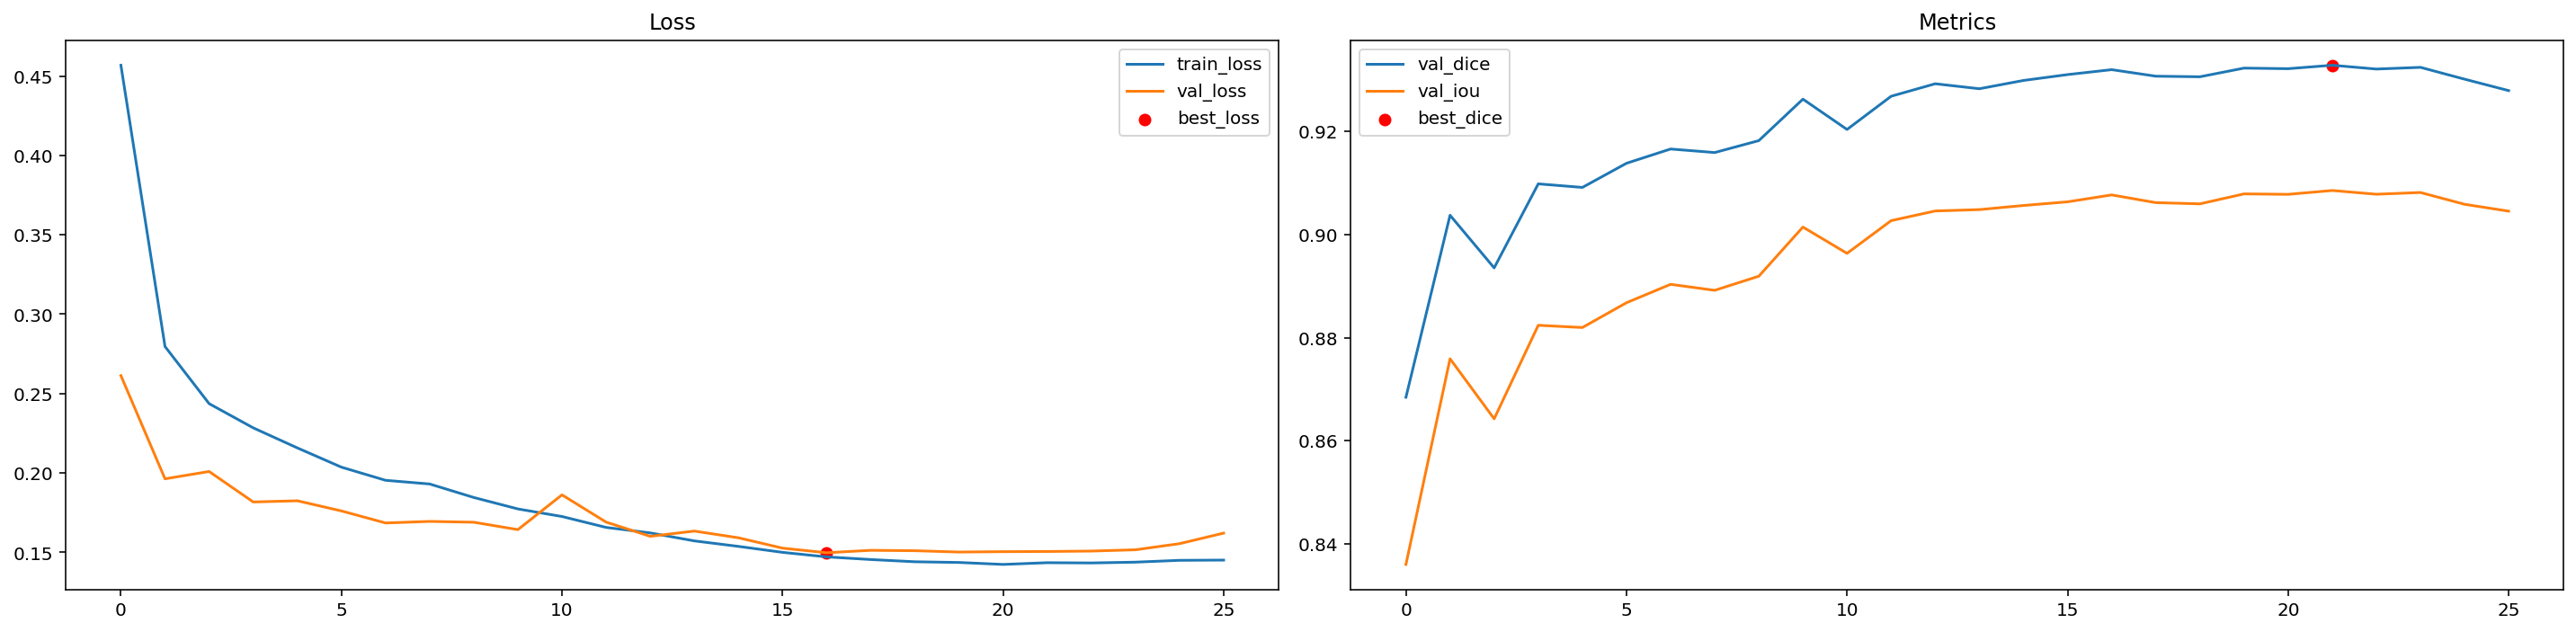

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(
    history["train_loss"],
    label="train_loss",
)
plt.plot(history["val_loss"], label="val_loss")
plt.scatter(
    history["best_loss_epoch"], history["best_loss"], color="r", label="best_loss"
)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Metrics")
plt.plot(history["val_dice"], label="val_dice")
plt.plot(history["val_iou"], label="val_iou")
plt.scatter(
    history["best_dice_epoch"], history["best_dice"], color="r", label="best_dice"
)
plt.legend()
plt.tight_layout()
plt.show();

In [17]:
model.load_state_dict(best_weights["dice"])

<All keys matched successfully>

In [28]:
# model.load_state_dict(best_weights["loss"])

In [18]:
test_ds = Dataset(
    df=df[(df["fold"] == CONFIG["FOLD"]) & (df["is_mask"])],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col="3D_npy_bf",
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=None,
    pad=True,
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=40, shuffle=False, num_workers=0
)


In [19]:
imgs, masks = next(iter(test_loader))

In [20]:
with torch.no_grad():
    predictions = torch.nn.Sigmoid()(model(imgs.to("cuda"))).detach().cpu().numpy()

imgs = imgs.detach().cpu().numpy()
masks = masks.detach().cpu().numpy()

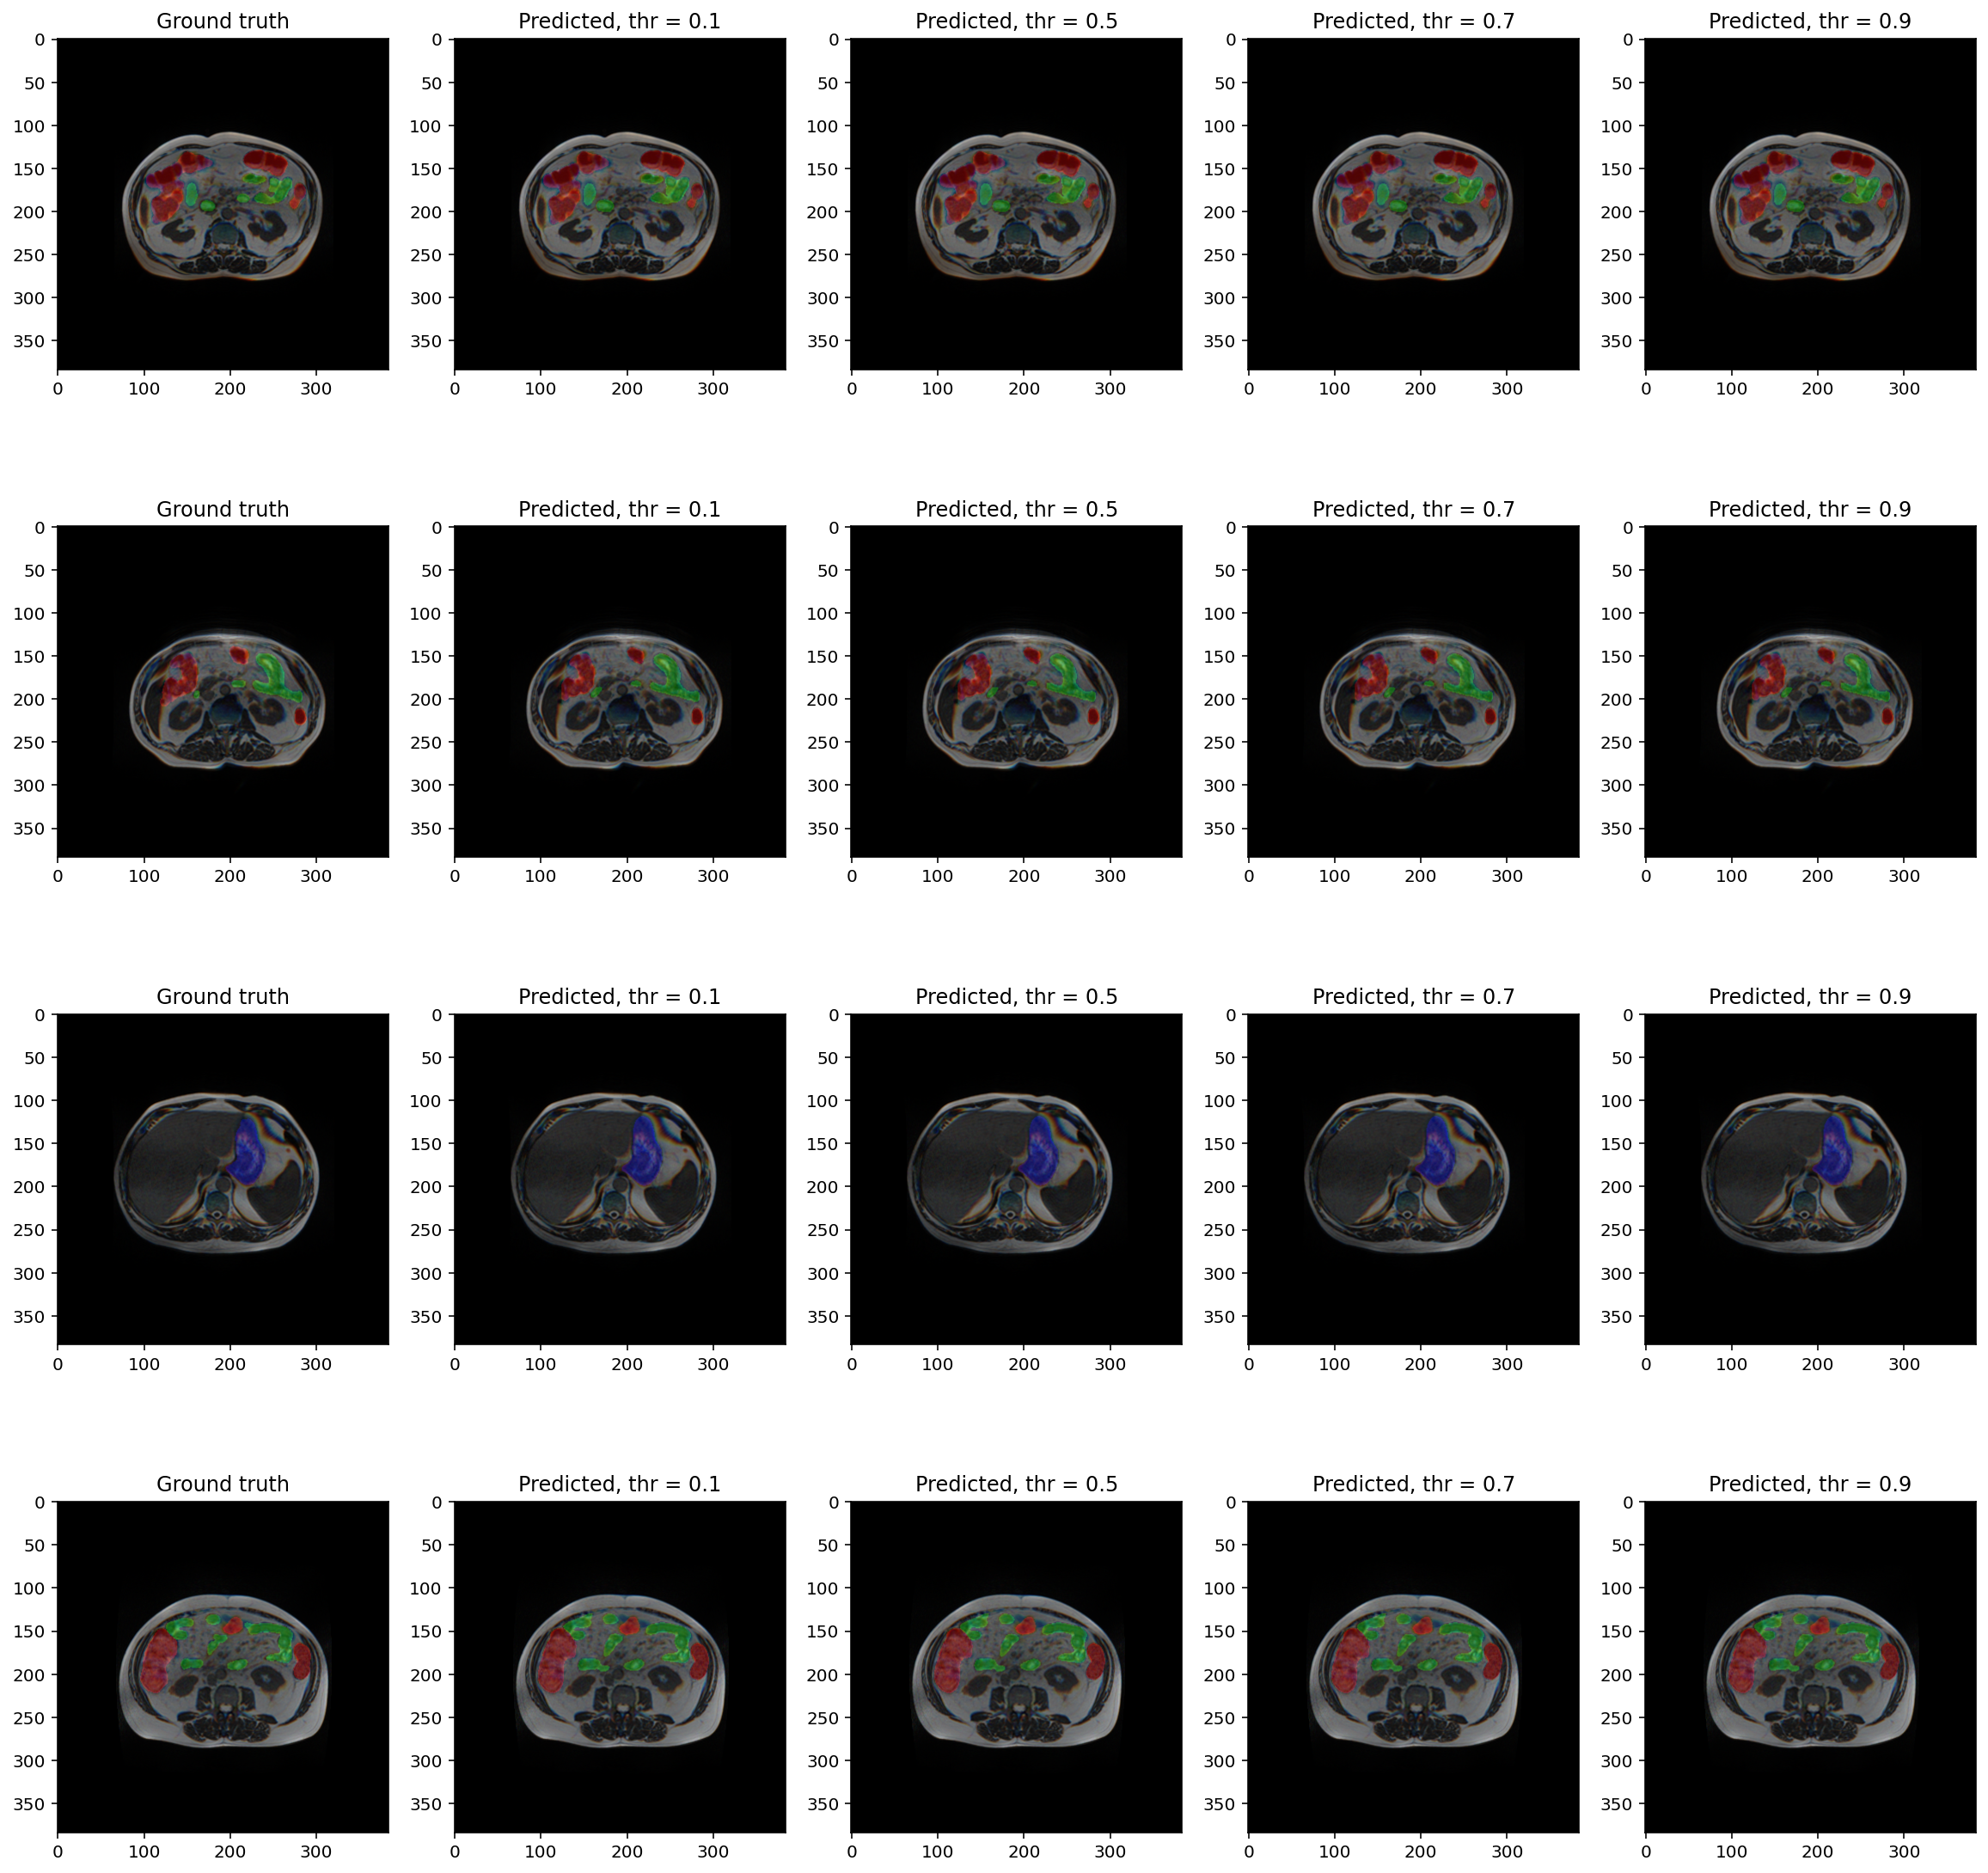

In [21]:
thr = [0.1, 0.5, 0.7, 0.9]

plt.figure(figsize=(20, 20))
for i in range(0, 20, 5):
    pred = predictions[i]
    mask = masks[i]
    img = imgs[i]
    plt.subplot(4, 5, i + 1)
    plt.title("Ground truth")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask.astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 2)
    plt.title(f"Predicted, thr = {thr[0]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[0]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 3)
    plt.title(f"Predicted, thr = {thr[1]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[1]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 4)
    plt.title(f"Predicted, thr = {thr[2]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[2]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 5)
    plt.title(f"Predicted, thr = {thr[3]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[3]).astype("float32"), 0, 2), alpha=0.3)
plt.show();

In [22]:
CONFIG["MODEL_PATH"]

'/app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/'

In [24]:
!kaggle datasets init -p {CONFIG["MODEL_PATH"]}

Data package template written to: /app/_data/models/unet_fold_1_two_sided_seed_42_seq_1/dataset-metadata.json


In [25]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "r") as f:
    meta = json.load(f)

In [26]:
name = f"unet-f{CONFIG['FOLD']}-s{CONFIG['SEED']}-2sided-seq1"
meta["title"] = name
meta["id"] = f"nataliayurasova/{name}"

In [27]:
meta

{'title': 'unet-f1-s42-2sided-seq1',
 'id': 'nataliayurasova/unet-f1-s42-2sided-seq1',
 'licenses': [{'name': 'CC0-1.0'}]}

In [28]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "w") as f:
    json.dump(meta, f)

In [29]:
!kaggle datasets create -p {CONFIG["MODEL_PATH"]} -r zip

Starting upload for file weights.zip
100%|████████████████████████████████████████| 356M/356M [04:41<00:00, 1.32MB/s]
Upload successful: weights.zip (356MB)
Starting upload for file history.json
100%|██████████████████████████████████████| 2.73k/2.73k [00:02<00:00, 1.21kB/s]
Upload successful: history.json (3KB)
Starting upload for file config.json
100%|████████████████████████████████████████████| 432/432 [00:02<00:00, 163B/s]
Upload successful: config.json (432B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/nataliayurasova/unet-f1-s42-2sided-seq1
